# Volatility surface calibration
#### Dmitry Bazanov, Roland Grinis, Ivan Novikov

In [1]:
import torch
import numpy as np
import numba as nb
import pandas as pd 
import sympy as sym
from scipy.stats import norm
import matplotlib.pyplot as plt
from importlib import reload
plt.style.use("dark_background")
%matplotlib inline
torch.manual_seed(987654);

## 1. Implied Volatility

#### 1.1 CDF Approximation
Zelen & Severo approximation for the standard normal CDF $\text{N}(x) = \frac{1}{\sqrt{2\pi}}\int^x_{-\infty} \text{d}z \exp(-z^2/2)$ is given by: 
$$
\text{N}(x) = 1 - \text{N}'(x) \sum_{i=1}^{5} b_i t^i + \epsilon (x)
$$
where $t = (1 + b_0 x)^{-1}$, the error is bounded by $|\epsilon (x)| < 7.5 \cdot 10^{-8}$ and the coefficients $b_i$ are fixed (see implementation).

$$
b_0 = 0.2316419 
$$
$$
b_1 = 0.319381530 
$$
$$
b_2 = -0.356563782 
$$
$$
b_3 = 1.781477937 
$$
$$
b_4 = -1.821255978 
$$
$$
b_5 = 1.330274429
$$

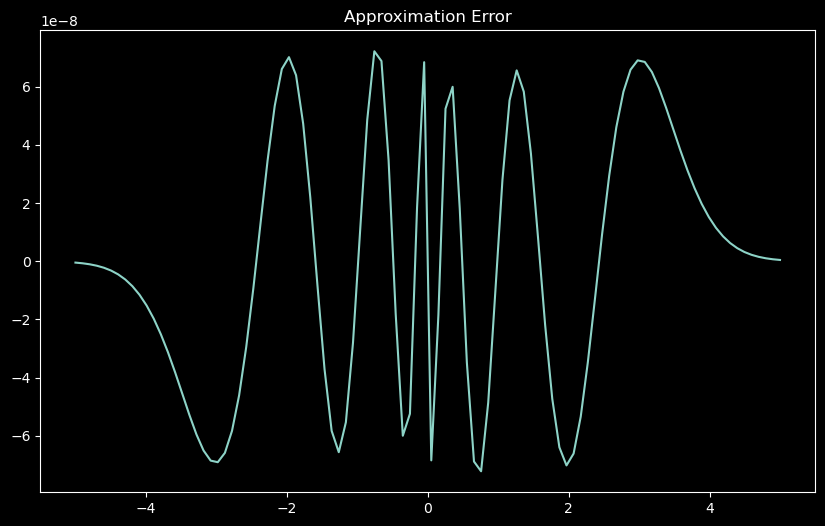

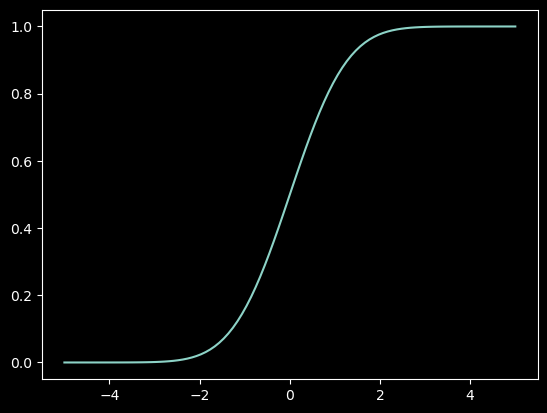

In [2]:
from pyquant.utils import normal_cdf

x = np.linspace(-5, 5, 100)
N0 = norm.cdf(x)
N1 = tuple(map(normal_cdf, x))

plt.figure(figsize=(10,6))
plt.plot(x, N0 - np.array(N1))
plt.title('Approximation Error')
plt.show()

plt.plot(x, N1);

#### 1.2 Black-Scholes-Merton formulae revisited

Present value:
$$
PV_{C,P} = \pm S_t \text{N}(\pm d_1) - \pm e^{-r(T-t)}K \text{N}(\pm d_2)
$$

where $d_1 = \frac{\log \frac{f_t}{K} + \frac{1}{2}\sigma^2(T-t) }{\sigma \sqrt{T-t}}$ and $d_2 = d_1 - \sigma \sqrt{T-t}$


Delta risk:
$$
\Delta_{C,BSM} = \frac{\partial PV_C}{\partial S_t} = N(d_1), \quad \Delta_{P,BSM} = \frac{\partial PV_P}{\partial S_t} = \Delta_{C,BSM} - 1
$$

Gamma risk:
$$
\Gamma_{BSM} =  \frac{\partial \Delta_{BSM}}{\partial S_t} = \frac{\text{N}'(d_1)}{S_t\sigma \sqrt{T-t}}
$$

Vega risk:
$$
\mathcal{V}_{BSM}= \frac{\partial PV}{\partial \sigma} =\text{N}'(d_1) S_t \sqrt{T-t}
$$

Vanna risk:
$$
\text{Vanna}_{BSM} = \frac{\partial \mathcal{V}_{BSM}}{\partial S_t} = \mathcal{V}_{BSM} \cdot \frac{d_2}{\sigma S_t}
$$

Volga/Vomma risk:
$$
\text{Volga}_{BSM} =  \frac{\partial \mathcal{V}_{BSM}}{\partial \sigma} = \mathcal{V}_{BSM} \frac{d_1 d_2}{\sigma}
$$

#### 1.2 Newton-Raphson for Implied Volatility

Implied volatility is defined as the volatility level $\sigma$ one needs to plug into the Black-Scholes formula $\mathcal{BS}$ to obtain the market present value $PV^{m k t}$ of the option:

$$
g\left(\sigma_{\text {imp }}\right)=PV^{m k t}(K, T)-\mathcal{BS}\left(t_0=0, S_0 ; K, T, \sigma_{\text {imp }}, r\right)=0 
$$

Given an initial guess for the implied volatility, i.e. $\sigma_{\text {imp }}^{(0)}$, we can find the next approximations, $\sigma_{\text {imp }}^{(k)}, k=1,2, \ldots$, by means of the Newton-Raphson iterative algorythm, as follows

$$
\sigma_{\text {imp }}^{(k+1)}=\sigma_{\text {imp }}^{(k)}-\frac{g\left(\sigma_{\text {imp }}^{(k)}\right)}{g^{\prime}\left(\sigma_{\text {imp }}^{(k)}\right)}, \text { for } k \geq 0 .
$$
where actually the derivative is negative vega:
$$
g^{\prime}\left(\sigma_{\text {imp }}^{(k)} \right) = - \mathcal{V}_{BSM}(\sigma_{\text {imp}}^{(k)})
$$
This algorithm has second order convergence.

For deep OTM options vega is close to zero - this might lead to instabilities for the Newton-Raphson method. To deal with this, we augment the later with the bisection method.

#### 1.3 Delta-space quotes

In some markets, e.g. FX, quotes for the volatility smile are not presented as an options chain of strikes and implied vols. Rather, markets makers quote:
- the ATM straddle $\sigma_{ATM} = \sigma(K=f_t)$
- the risk-reversal $\sigma_{\delta RR} = \sigma(K_{\delta,c}) - \sigma(K_{\delta,p})$
- the butterfly $\sigma_{\delta BB} = \frac{1}{2}[\sigma(K_{\delta,c}) + \sigma(K_{\delta,p})] - \sigma_{ATM}$

where $K_{\delta,c}$ and $K_{\delta,p}$ are respectively call and put strikes for which the Black-Scholes delta is exatly $\Delta_{BSM} = \pm \delta$. Typically one takes $\delta=\frac{1}{4}$ and $\delta=\frac{1}{10}$ for 25RR, 25BB and 10RR, 10BB respectively. One can easily map delta-space quotes to strikes chain solving:
$$
g(K) = \Delta_{BSM} \pm \delta = 0
$$
which reduces to $\text{N}(d_{+}) = \delta$ for calls and $\text{N}(d_{+}) = 1 - \delta$ for puts. The easiest approach to find the root will be Newton-Raphson with:
$$
g'(K) = -\frac{1}{K \sigma \sqrt{T-t}}\text{N}'(d_{+}) 
$$

In [3]:
from pyquant.black_scholes import *

In [4]:
bs_calc = BlackScholesCalc()

In [5]:
K_put = bs_calc.strike_from_delta(Forward(Spot(100.), ForwardYield(0.01), Tenor(0.8)), 
                                        Delta(-0.25), ImpliedVol(0.3))
abs(bs_calc.delta(Forward(Spot(100.), ForwardYield(0.01), Tenor(0.8)),
         K_put, ImpliedVol(0.3), OptionType(is_call=False)).pv + 0.25)

0.0

In [6]:
K_put = bs_calc.strike_from_delta(Forward(Spot(100.), ForwardYield(0.01), Tenor(0.8)), 
                                        Delta(-0.1), ImpliedVol(0.3))
abs(bs_calc.delta(Forward(Spot(100.), ForwardYield(0.01), Tenor(0.8)),
         K_put, ImpliedVol(0.3), OptionType(is_call=False)).pv + 0.1)

2.7755575615628914e-17

In [7]:
K_call = bs_calc.strike_from_delta(Forward(Spot(100.), ForwardYield(0.01), Tenor(0.8)), 
                                        Delta(0.25), ImpliedVol(0.3))
abs(bs_calc.delta(Forward(Spot(100.), ForwardYield(0.01), Tenor(0.8)),
         K_call, ImpliedVol(0.3), OptionType(is_call=True)).pv - .25)

1.970645868709653e-14

In [8]:
K_call = bs_calc.strike_from_delta(Forward(Spot(100.), ForwardYield(0.01), Tenor(0.8)), 
                                        Delta(0.1), ImpliedVol(0.3))
abs(bs_calc.delta(Forward(Spot(100.), ForwardYield(0.01), Tenor(0.8)),
         K_call, ImpliedVol(0.3), OptionType(is_call=True)).pv - .1)

6.938893903907228e-17

In [9]:
PV_put = bs_calc.premium(
    Forward(Spot(100.), ForwardYield(0.01), Tenor(0.8)), 
    Strike(80.),
    ImpliedVol(.3), 
    OptionType(False)
)
abs(bs_calc.implied_vol(
    Forward(Spot(100.), ForwardYield(0.01), Tenor(0.8)), 
    Strike(80.), 
    PV_put,
    OptionType(False)).sigma - .3)

1.6887047316060944e-12

In [10]:
PV_call = bs_calc.premium(
    Forward(Spot(100.), ForwardYield(0.01), Tenor(0.8)), 
    Strike(120.),
    ImpliedVol(.3), 
    OptionType(True)
)
abs(bs_calc.implied_vol(
    Forward(Spot(100.), ForwardYield(0.01), Tenor(0.8)), 
    Strike(120.), 
    PV_call,
    OptionType(True)).sigma - .3)

1.913857961000076e-12

In [11]:
put_strikes = np.array([1300., 1400, 1500, 1600, 1700])
call_strikes = np.array([1800., 1900, 2000, 2100, 2200])
tenor = 0.01
forward = 1723.75
puts = np.array([ 1.72375 ,  1.72375 ,  3.4475  ,  6.895   , 26.718125])
calls = np.array([11.204375,  4.309375,  1.72375 ,  0.861875,  0.861875])

In [12]:
@nb.njit()
def get_implied_vols(
    forward,
    tenor,
    strikes,
    forward_values,
    is_call=True
):
    n = len(strikes)
    ivols = np.zeros(n, dtype=np.float64)
    bs = BlackScholesCalc()
    for index in range(n):
        K = strikes[index]
        FV = forward_values[index]
        ivols[index] = bs.implied_vol(
            Forward(Spot(forward), ForwardYield(0.), Tenor(tenor)),
            Strike(K), 
            Premium(FV),
            OptionType(is_call)
        ).sigma
    return ivols

In [13]:
strikes = np.concatenate((put_strikes, call_strikes))
implied_vols = np.concatenate((
    get_implied_vols(
        forward,
        tenor,
        put_strikes,
        puts,
        is_call=False
    ),
    get_implied_vols(
        forward,
        tenor,
        call_strikes,
        calls,
        is_call=True
    )                    
))

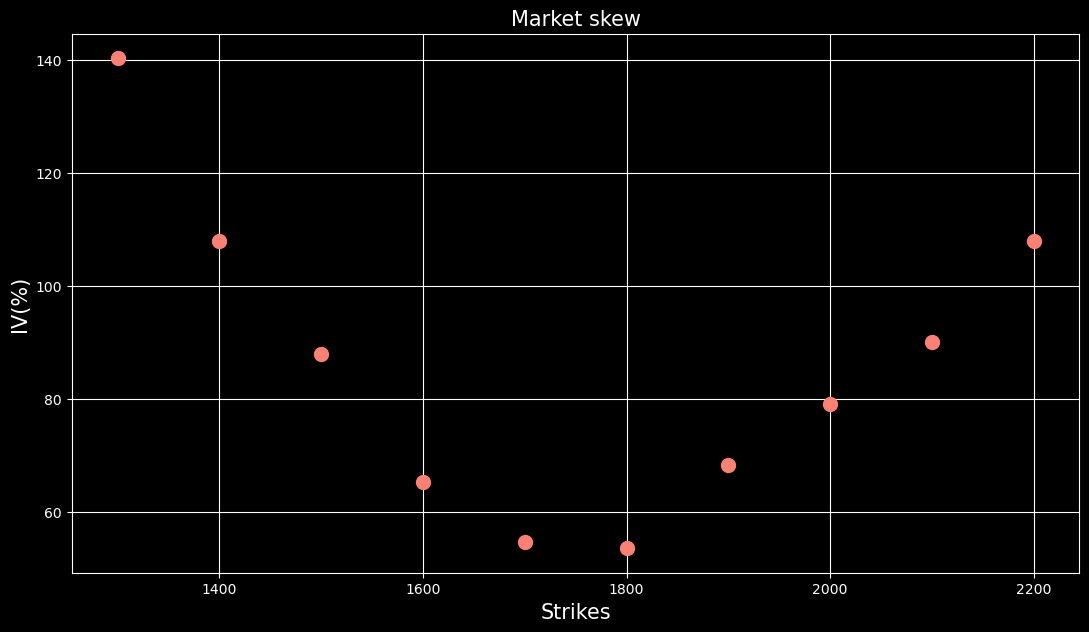

In [14]:
plt.figure(figsize=(13, 7))
plt.plot(strikes, 100*implied_vols, '.C3', markersize=20)
plt.title('Market skew', fontsize=15)
plt.xlabel('Strikes', color='white', fontsize=15)
plt.ylabel('IV(%)', color='white', fontsize=15)
plt.grid()
plt.show()

## 2. Levenberg-Marquardt algorithm

The Levenberg-Marquardt algorithm combines two numerical minimization algorithms: the gradient descent method and the
Gauss-Newton method. In the gradient descent method, the sum of the squared errors is reduced by updating the parameters in the steepest-descent direction. In the
Gauss-Newton method, the sum of the squared errors is reduced by assuming the least
squares function is locally quadratic in the parameters, and finding the minimum of
this quadratic. The Levenberg-Marquardt method acts more like a gradient-descent
method when the parameters are far from their optimal value, and acts more like the
Gauss-Newton method when the parameters are close to their optimal value.

["The Levenberg-Marquardt algorithm for
nonlinear least squares curve-fitting problems" Henri P. Gavin 2022](https://people.duke.edu/~hpgavin/ExperimentalSystems/lm.pdf)

##### Levenberg-Marquardt

$$
\chi^2(\boldsymbol{\theta}) =(\boldsymbol{\sigma}-\hat{\boldsymbol{\sigma}}(\boldsymbol{\theta}))^{\top} \boldsymbol{W}(\boldsymbol{\sigma}-\hat{\boldsymbol{\sigma}}(\boldsymbol{\theta}));
$$

$$ W_{ii} = \frac{1}{w_i^2}, \quad \sigma = [\sigma_i], \quad \hat{\sigma} = [\hat{\sigma_i}] $$

##### Gradient descent

$$
\begin{aligned}
\frac{\partial}{\partial \boldsymbol{\theta}} \chi^2 & =-2(\boldsymbol{\sigma}-\hat{\boldsymbol{\sigma}})^{\top} \boldsymbol{W} \boldsymbol{J}; \quad \boldsymbol{J} = \left[\frac{\partial \hat{\boldsymbol{y}}(\boldsymbol{p})}{\partial \boldsymbol{p}}\right]
\end{aligned}
$$

$$ \text{step: } h_g = \lambda \boldsymbol{J}^T \boldsymbol{W} (\boldsymbol{\sigma}-\hat{\boldsymbol{\sigma}}); \quad \lambda > 0 \text{ - learning rate} $$

##### Gauss-Newton Method  $ \quad |h| << 1 $

$$\hat{\boldsymbol{\sigma}}(\boldsymbol{\theta}+\boldsymbol{h}) \approx \hat{\boldsymbol{\sigma}}(\boldsymbol{\theta})+\boldsymbol{J} \boldsymbol{h}$$

Note the approximations:
$$
\chi^2(\boldsymbol{\theta}+\boldsymbol{h}) \approx \boldsymbol{\sigma}^{\top} \boldsymbol{W} \boldsymbol{\sigma}+\hat{\boldsymbol{\sigma}}^{\top} \boldsymbol{W} \hat{\boldsymbol{\sigma}}-2 \boldsymbol{\sigma}^{\top} \boldsymbol{W} \hat{\boldsymbol{\sigma}}-2(\boldsymbol{\sigma}-\hat{\boldsymbol{\sigma}})^{\top} \boldsymbol{W} \boldsymbol{J} \boldsymbol{h}+\boldsymbol{h}^{\top} \boldsymbol{J}^{\top} \boldsymbol{W} \boldsymbol{J} \boldsymbol{h}
$$
so that
$$
\frac{\partial}{\partial \boldsymbol{h}} \chi^2(\boldsymbol{\theta}+\boldsymbol{h}) \approx-2(\boldsymbol{\sigma}-\hat{\boldsymbol{\sigma}})^{\top} \boldsymbol{W} \boldsymbol{J}+2 \boldsymbol{h}^{\top} \boldsymbol{J}^{\top} \boldsymbol{W} \boldsymbol{J}
$$

Hence the optimal step:
$$
\left[\boldsymbol{J}^{\top} \boldsymbol{W} \boldsymbol{J}\right] \boldsymbol{h}_{\mathrm{gn}}=\boldsymbol{J}^{\top} \boldsymbol{W}(\boldsymbol{\sigma}-\hat{\boldsymbol{\sigma}})
$$

##### Levenberg Equation

$$
\left[\boldsymbol{J}^{\top} \boldsymbol{W} \boldsymbol{J}+\lambda \boldsymbol{I}\right] \boldsymbol{h}_{\mathrm{lm}}=\boldsymbol{J}^{\top} \boldsymbol{W}(\boldsymbol{\sigma}-\hat{\boldsymbol{\sigma}})
$$

##### Levenberg-Marquardt equation

$$
\left[\boldsymbol{J}^{\top} \boldsymbol{W} \boldsymbol{J}+\lambda \operatorname{diag}\left(\boldsymbol{J}^{\top} \boldsymbol{W} \boldsymbol{J}\right)\right] \boldsymbol{h}_{\mathrm{Im}}=\boldsymbol{J}^{\top} \boldsymbol{W}(\boldsymbol{y}-\hat{\boldsymbol{y}})
$$

##### Improvement metric

$$
\mu\left(\boldsymbol{h}_{\mathrm{lm}}\right)=\frac{\chi^2(\boldsymbol{\theta})-\chi^2\left(\boldsymbol{\theta}+\boldsymbol{h}_{\mathrm{lm}}\right)}{(\boldsymbol{\sigma}-\hat{\boldsymbol{\sigma}})^{\top} \boldsymbol{W}(\boldsymbol{\sigma}-\hat{\boldsymbol{\sigma}})-\left(\boldsymbol{\sigma}-\hat{\boldsymbol{\sigma}}-\boldsymbol{J} \boldsymbol{h}_{\mathrm{lm}}\right)^{\top} \boldsymbol{W}\left(\boldsymbol{\sigma}-\hat{\boldsymbol{\sigma}}-\boldsymbol{J} \boldsymbol{h}_{\mathrm{lm}}\right)}
$$

$$
\mu << 1 \quad \rightarrow \quad \text{Gradient descent mode} \quad (\boldsymbol{\lambda} \text{ - is increasing})
$$

$$
\mu >> 1 \quad \rightarrow \quad \text{Gauss-Newton mode } \quad (\boldsymbol{\lambda} \text{ - is decreasing})
$$

$$
\boldsymbol{\mu}_{\lambda}(\boldsymbol{h}_{\mathrm{lm}}) = \frac{\chi^2(\boldsymbol{\theta})-\chi^2\left(\boldsymbol{\theta}+\boldsymbol{h}_{\mathrm{lm}}\right)}{\boldsymbol{h}_{\mathrm{lm}}^{\top}\left(\lambda \operatorname{diag}\left(\boldsymbol{J}^{\top} \boldsymbol{W} J\right) \boldsymbol{h}_{\mathrm{lm}}+\boldsymbol{J}^{\top} \boldsymbol{W}(\boldsymbol{\sigma}-\hat{\boldsymbol{\sigma}}(\boldsymbol{\theta}))\right)}
$$

##### Step procedure

$$ \boldsymbol{\lambda} = 10^{-2}  \quad \quad \boldsymbol{L} \downarrow = 9 \quad \quad \boldsymbol{L} \uparrow = 11 \quad \quad \boldsymbol{\epsilon} = 10^{-1} $$

$$ \text{solve the L-M equation with  } \boldsymbol{\lambda} \quad \rightarrow \quad \boldsymbol{h}_{\mathrm{lm}} $$

$$
\begin{aligned}
& \text{if } \quad \boldsymbol{N}_{\lambda} (\boldsymbol{h}_{\mathrm{lm}}) > \boldsymbol{\epsilon}: \\
& \quad \quad \boldsymbol{\theta} = \boldsymbol{\theta} + \boldsymbol{h}_{\mathrm{lm}} \\
& \quad \quad \boldsymbol{\lambda} = \max (\frac{\lambda}{L \uparrow}, 10^{-7}) \\
& \text{else: } \\
&  \quad \quad \boldsymbol{\lambda} = \min (\lambda L \uparrow , 10^{7})
\end{aligned}
$$

##### Convergence Criteria

- Gradient convergence: $\max \left|\boldsymbol{J}^{\top} \boldsymbol{W}(\boldsymbol{y}-\hat{\boldsymbol{y}})\right|< 10^{-3}$;
- Parameters convergence: $\max \left|h_i / p_i\right|<10^{-3} ;$ or
- Convergence in $\chi^2:$ uses the value of the reduced $\chi^2, \chi_\nu^2=\chi^2 /(m-n+1)<10^{-1}$.  (where $n$ - sample size, $m$ - param. dimension)

##### Error analysis

$$ \chi_\nu^2 >> 1 \text{ - poor fit };  \quad \chi_\nu^2 \approx 1 \text{ - fit error of same order as measurement error }; \quad \chi_\nu^2 << 1 \text{ - overfit }; $$

$$ \text{parameters covariance: } (\boldsymbol{J}^{\top} \boldsymbol{W} \boldsymbol{J})^{-1} $$

## 3. SABR calibration

This is a stochastic volatility model that describes the dynamics of the forward directly in the risk neutral measure:

$$ df_t = \alpha_t f_t^{\beta} dW_t^1 $$ 
$$ d \alpha_t = v \alpha_t dW_t^2$$ 
$$E[dW_t^1, dW_t^2] = \rho dt$$

where $-1 < \rho < 1$ is the vol correlation, $0 \leq \beta \leq 1$ is the CIR exponent and the Wiener processes are independent.

Hagan's original formula has arbitrage for small strikes and large maturities, and is inconsistent as $\beta \rightarrow 1$. The corrected implied vol parametrisation is given by:
$$x = \ln \frac{f}{K}$$

$$ \sigma_B(x, T) \approx I_B^0(x) (1 + I_H^1(x)T)$$

$$I_H^1(x) = \frac{\alpha^{2} \left(K f\right)^{\beta - 1} \left(1 - \beta\right)^{2}}{24} + \frac{\alpha \beta \rho v \left(K f\right)^{\frac{\beta}{2} - \frac{1}{2}}}{4} + \frac{v^{2} \cdot \left(2 - 3 \rho^{2}\right)}{24}$$

The order zero term is treated below.

For ATM we can approximate the formula as:
$$\sigma_{ATM} = \sigma_{B} (f, f) \approx  \frac{\alpha(1+[\frac{(1-\beta)^2}{24} \frac{\alpha^2}{(f)^{2-2\beta}} + \frac{\rho \beta v \alpha}{4(f)^{(1-\beta)}}+\frac{2-3\rho^2}{24}v^2]T)}{f^{1 - \beta}} $$
The backbone $\beta$ should satisfy:
$$\ln \sigma_{ATM} \approx \ln \alpha - (1 - \beta) \ln {f}$$

In [15]:
alpha, beta, v, rho, f, K, T = sym.symbols('alpha beta v rho f K T')
x = sym.log(f/K)
I_H_1 = (((1 - beta)**2)*alpha**2/(24*(f*K)**(1 - beta)) + (rho*v*alpha*beta)/(4*(f*K)**((1-beta)/2)) + 
 ((2 - 3*rho**2)*v**2)/24 )

Derivatives of $I_H^1(x)$:

In [16]:
I_H_1.diff(alpha) # vega
I_H_1.diff(rho) # rega
I_H_1.diff(v) # sega
I_H_1.diff(f) # delta
I_H_1.diff(f).diff(f) # gamma
I_H_1.diff(f).diff(alpha) # gamma, vanna, volga
I_H_1.diff(alpha).diff(alpha) # volga
I_H_1.diff(K); # map to delta space

Derivatives of $I_H^0(x)$:

$\textbf{Case 1}: x = 0$ 

In [17]:
I_B_x = alpha*K**(beta-1)
I_B_x

K**(beta - 1)*alpha

In [18]:
I_B_x.diff(alpha) # vega
I_B_x.diff(rho) # rega
I_B_x.diff(v) # sega
I_B_x.diff(f) # delta
I_B_x.diff(f).diff(f) # gamma
I_B_x.diff(f).diff(alpha) # gamma, vanna, volga
I_B_x.diff(alpha).diff(alpha) # volga
sym.simplify(I_B_x.diff(K)); # map to delta space

$\textbf{Case 2}: v = 0$ 

In [19]:
I_B_v = x*alpha*(1 - beta)/(f**(1 - beta) - K**(1 - beta))
I_B_v

alpha*(1 - beta)*log(f/K)/(-K**(1 - beta) + f**(1 - beta))

In [20]:
I_B_v.diff(alpha).subs(x, "x") # vega
I_B_v.diff(rho) # rega
I_B_v.diff(v) # sega
sym.simplify(I_B_v.diff(f).subs(x, "x")) # delta
sym.simplify(I_B_v.diff(f).diff(f).subs(x, "x")) # gamma
I_B_v.diff(f).diff(alpha).subs(x, "x") # gamma, vanna, volga
I_B_v.diff(alpha).diff(alpha) # volga
sym.simplify(I_B_v.diff(K).subs(x, "x")); # map to delta space

$\textbf{Case 3}: \beta = 1$

In [21]:
z_b = v*x/alpha
xi_b = sym.sqrt(- 2*rho*z_b+z_b**2+1 )
I_B_b = v*x/sym.ln((xi_b + z_b - rho)/(1 - rho))
I_B_b

v*log(f/K)/log((-rho + sqrt(1 - 2*rho*v*log(f/K)/alpha + v**2*log(f/K)**2/alpha**2) + v*log(f/K)/alpha)/(1 - rho))

In [22]:
# vega
sym.simplify(I_B_b.diff(alpha).subs(xi_b, sym.Symbol(r"\xi")).subs(z_b, "z").subs(x, "x"))
# rega
sym.simplify(I_B_b.diff(rho).subs(xi_b, sym.Symbol(r"\xi")).subs(z_b, "z").subs(x, "x"))
# sega
sym.simplify(I_B_b.diff(v).subs(xi_b, sym.Symbol(r"\xi")).subs(z_b, "z").subs(x, "x"))
# delta
sym.simplify(I_B_b.diff(f).subs(xi_b, sym.Symbol(r"\xi")).subs(z_b, "z").subs(x, "x"))
# gamma
sym.simplify(I_B_b.diff(f).diff(f).subs(xi_b, sym.Symbol(r"\xi")).subs(z_b, "z").subs(x, "x"))
# gamma, vanna, volga
sym.simplify(I_B_b.diff(f).diff(alpha).subs(xi_b, sym.Symbol(r"\xi")).subs(z_b, "z").subs(x, "x"))
# volga
sym.simplify(I_B_b.diff(alpha).diff(alpha).subs(xi_b, sym.Symbol(r"\xi")).subs(z_b, "z").subs(x, "x"))
# map to delta space
sym.simplify(I_B_b.diff(K).subs(xi_b, sym.Symbol(r"\xi")).subs(z_b, "z").subs(x, "x"));

$\textbf{Case 4}: \beta < 1$

In [23]:
z = v*(f**(1 - beta) - K**(1 - beta))/(alpha * (1 - beta))
xi = sym.sqrt(- 2*rho*z+z**2+1 )
I_B_0 = v*x/sym.ln((xi + z - rho)/(1 - rho))
I_B_0

v*log(f/K)/log((-rho + sqrt(1 - 2*rho*v*(-K**(1 - beta) + f**(1 - beta))/(alpha*(1 - beta)) + v**2*(-K**(1 - beta) + f**(1 - beta))**2/(alpha**2*(1 - beta)**2)) + v*(-K**(1 - beta) + f**(1 - beta))/(alpha*(1 - beta)))/(1 - rho))

In [24]:
# vega
sym.simplify(I_B_0.diff(alpha).subs(xi, sym.Symbol(r"\xi")).subs(z, "z").subs(x, "x"))
# rega
sym.simplify(I_B_0.diff(rho).subs(xi, sym.Symbol(r"\xi")).subs(z, "z").subs(x, "x"))
# sega
sym.simplify(I_B_0.diff(v).subs(xi, sym.Symbol(r"\xi")).subs(z, "z").subs(x, "x"))
# delta
sym.simplify(I_B_0.diff(f).subs(xi, sym.Symbol(r"\xi")).subs(z, "z").subs(x, "x"))
# gamma
sym.simplify(I_B_0.diff(f).diff(f).subs(xi, sym.Symbol(r"\xi")).subs(z, "z").subs(x, "x"))
# gamma, vanna, volga
sym.simplify(I_B_0.diff(f).diff(alpha).subs(xi, sym.Symbol(r"\xi")).subs(z, "z").subs(x, "x"))
# volga
sym.simplify(I_B_0.diff(alpha).diff(alpha).subs(xi, sym.Symbol(r"\xi")).subs(z, "z").subs(x, "x"))
# map to delta space
sym.simplify(I_B_0.diff(K).subs(xi, sym.Symbol(r"\xi")).subs(z, "z").subs(x, "x"));

Implied volatility senstivities are easy to obtain:
$$ \nabla_{\alpha, \rho, v, f, K} \sigma_B(x, T) =  \nabla_{\alpha, \rho, v, f, K} I_B^0(x) \cdot \left(1 + I_H^1(x)T \right) + I_B^0(x) \cdot T \cdot \nabla_{\alpha, \rho, v, f, K}I_H^1(x)
$$

$$
\nabla_{\alpha, f}^2 \sigma_B= \nabla_{\alpha, f}^2 I_B^0(x) + T\left( \nabla_{\alpha,f}^2 I_B^0(x) \cdot I_H^1(x) +  \nabla_{\alpha, f}^2  I_H^1(x) \cdot I_B^0(x)  + 2 \nabla_{\alpha, f} I_B^0(x) \cdot \nabla_{\alpha, f} I_H^1(x) \right)
$$

$$ \frac{\partial ^2 \sigma_B}{\partial \alpha \partial f} = \frac{\partial^2 I_B^0(x)}{\partial \alpha \partial f} (1 + I_H^1(x)T) + \frac{\partial I_B^0(x)}{\partial \alpha} \frac{\partial I_H^1(x)}{\partial f}T + \frac{\partial^2 I_H^1(x)}{\partial \alpha \partial f} I_B^0(x) T +\frac{\partial I_H^1(x)}{\partial \alpha} \frac{\partial I_B^0(x)}{\partial f}T $$

#### SABR greeks
Letting $PV = PV_B(\sigma_B)$ to be the present value of a call option (premium), with $PV_B$ denoting the Black-Scholes formula and $\sigma_B$ SABR implied vol. 
The forward value is:
$$
FV =\frac{PV}{D}
$$
where $D$ is our numeraire (or discounting), so that the spot is $S = D \cdot f$

The SABR greeks are given below in terms of Black-Scholes-Merton greeks:

* Sticky Delta (for the call):
$$\Delta_C =  \frac{\partial PV}{\partial S} =  \frac{1}{D}\frac{\partial PV}{\partial f} =  \frac{1}{D}\frac{\partial PV_B}{\partial f} + \frac{1}{D}\frac{\partial PV_B}{\partial \sigma_B} \cdot \left( \frac{\partial \sigma_B}{\partial f} + \frac{\partial \sigma_B}{\partial \alpha}  \frac{\rho v}{f^\beta} \right) = $$
$$ = \Delta_{C,BSM} + \frac{1}{D}\mathcal{V}_{BSM} \cdot \left( \frac{\partial \sigma_B}{\partial f} + \frac{\partial \sigma_B}{\partial \alpha}  \frac{\rho v}{f^\beta} \right)$$
For the put one can use the put-call parity:
$$\Delta_{P} = \Delta_{C} - 1$$

* Gamma: 
$$
\Gamma = \frac{\partial \Delta_C}{\partial S} = \frac{1}{D}\frac{\partial \Delta_C}{\partial f}
$$
$$
= \Gamma_{BSM} + \frac{2}{D}\text{Vanna}_{BSM} \cdot \left( \frac{\partial \sigma_B}{\partial f} + \frac{\partial \sigma_B}{\partial \alpha}  \frac{\rho v}{f^\beta} \right) 
$$
$$
+  \frac{1}{D^2}\text{Volga}_{BSM}\cdot \left( \frac{\partial \sigma_B}{\partial f} + \frac{\partial \sigma_B}{\partial \alpha}  \frac{\rho v}{f^\beta} \right) ^2
$$
$$
+ \frac{1}{D^2} \mathcal{V}_{BSM} \cdot \left( \frac{\partial ^2 \sigma_B}{\partial f^2} + \frac{\partial ^2 \sigma_B}{\partial \alpha \partial f}  \frac{\rho v}{f^\beta}  - \frac{\partial \sigma_B}{\partial \alpha}  \frac{\beta \rho v}{f^{\beta + 1}} \right)
$$


* Vega (ATM straddle):

$$
\mathcal{V} = \frac{\partial PV}{\partial \alpha} 
$$
$$
= \mathcal{V}_{BSM} \cdot \left( 
 \frac{\partial \sigma_B}{\partial \alpha} + \frac{\partial \sigma_B}{\partial f} \cdot \frac{\rho f^\beta}{v}\right)$$
 
 * Rega (risk reversal):
 $$ \mathcal{R} =\frac{ \partial PV}{\partial  \rho} = \mathcal{V}_{BSM} \frac{\partial \sigma_B}{\partial \rho}$$

 * Sega (butterfly):
$$ \mathcal{S} =\frac{ \partial PV}{\partial  v} = \mathcal{V}_{BSM} \frac{\partial \sigma_B}{\partial v}$$

* Vanna: 
$$
\mathcal{Vanna} = \frac{\partial \mathcal{V}}{\partial S } =\frac{1}{D} \frac{\partial \mathcal{V}}{\partial f }
$$
$$
= \left( \text{Vanna}_{BSM} + \frac{1}{D} \text{Volga}_{BSM}\cdot \left( \frac{\partial \sigma_B}{\partial f} + \frac{\partial \sigma_B}{\partial \alpha}  \frac{\rho v}{f^\beta} \right) \right)\cdot \left( 
 \frac{\partial \sigma_B}{\partial \alpha} + \frac{\partial \sigma_B}{\partial f} \cdot \frac{\rho f^\beta}{v}\right)
$$
$$
+ \frac{1}{D}\mathcal{V}_{BSM} \cdot \left( \frac{\partial ^2 \sigma_B}{\partial f \partial \alpha} + \frac{\partial ^2 \sigma_B}{\partial f^2}  \frac{\rho f^\beta}{v}  + \frac{\partial \sigma_B}{\partial f}  \frac{\beta \rho f^{\beta - 1}}{v} \right)
$$


* Volga: 
$$
\mathcal{Volga} = \frac{\partial \mathcal{V}}{\partial \alpha }
$$
$$
= \text{Volga}_{BSM} \cdot \left( 
 \frac{\partial \sigma_B}{\partial \alpha} + \frac{\partial \sigma_B}{\partial f} \cdot \frac{\rho f^\beta}{v}\right)^2
$$
$$
+ \mathcal{V}_{BSM} \cdot \left( \frac{\partial ^2 \sigma_B}{\partial \alpha^2} + \frac{\partial ^2 \sigma_B}{\partial f \partial \alpha}  \cdot \frac{\rho f^\beta}{v} \right)
$$

In [25]:
from pyquant.sabr import *

In [26]:
vol_smile_chain = VolSmileChain(
    Forward(Spot(forward), ForwardYield(0.), Tenor(tenor)),
    Strikes(strikes),
    ImpliedVols(implied_vols)
)

In [27]:
backbone = Backbone(0.95)

In [28]:
sabr_calc = SABRCalc()

In [33]:
calibrated_params = sabr_calc.calibrate(vol_smile_chain, backbone)
print(sabr_calc.calibration_error)
calibrated_params.array()

0.010898207420812758


array([ 0.66308619, -0.19797296, 10.53666218])

In [34]:
test_strikes = Strikes(np.linspace(strikes[0], strikes[-1], 100))

In [36]:
test_iv = sabr_calc.implied_vols(
    Forward(Spot(forward), ForwardYield(0.), Tenor(tenor)),
    test_strikes,
    calibrated_params
)

In [35]:
test_strikes = np.linspace(strikes[0], strikes[-1], 100)
test_iv,_,_ =  vol_sabr(
    forward,
    tenor,
    test_strikes,
    backbone,
    calibrated_params,
    compute_risk=False)

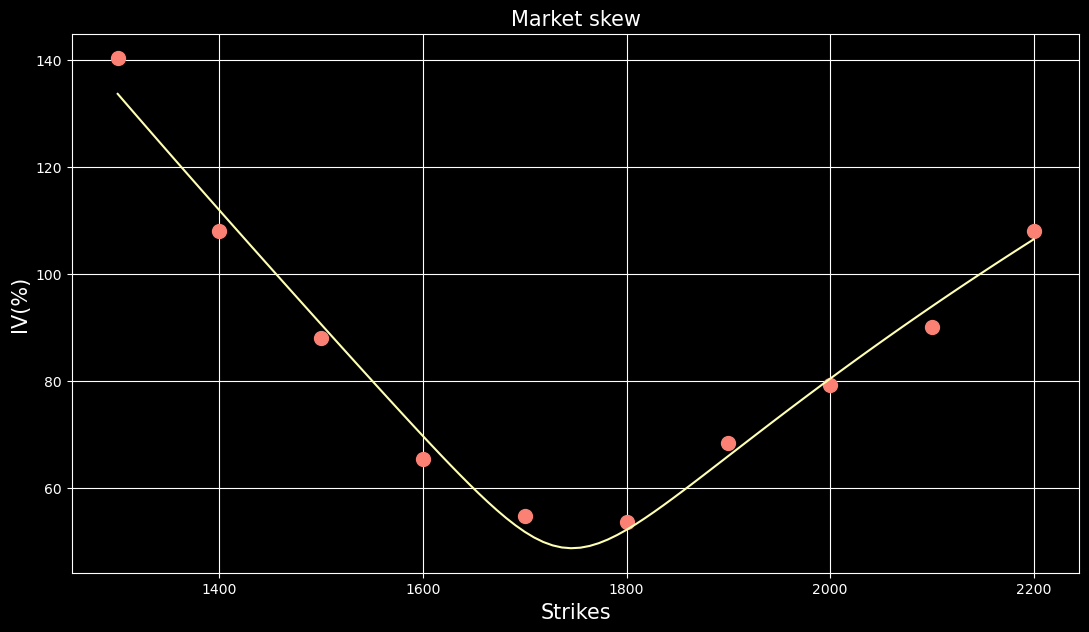

In [38]:
plt.figure(figsize=(13, 7))
plt.plot(strikes, 100*implied_vols, '.C3', markersize=20)
plt.plot(test_strikes.data, 100*test_iv.data, 'C1')
plt.title('Market skew', fontsize=15)
plt.xlabel('Strikes', color='white', fontsize=15)
plt.ylabel('IV(%)', color='white', fontsize=15)
plt.grid()
plt.show()

#### BSM limit

In [40]:
flat_implied_vols = np.ones_like(implied_vols)*0.8
flat_vol_smile_chain = VolSmileChain(
    Forward(Spot(forward), ForwardYield(0.), Tenor(tenor)),
    Strikes(strikes),
    ImpliedVols(flat_implied_vols)
)

In [53]:
sabr_calc.update_cached_params(
    SABRParams(Volatility(1.), Correlation(0.), VolOfVol(0.), Backbone(.9999))
)
sabr_calc.cached_params

array([1., 0., 0.])

In [55]:
flat_calibrated_params = sabr_calc.calibrate(flat_vol_smile_chain, Backbone(0.9999))
print(sabr_calc.calibration_error)
flat_calibrated_params.array()

2.78499815130457e-06


array([ 8.00719410e-01, -5.30796685e-04,  1.00000000e-04])

#### Warm starting

In [45]:
new_forward = 1723.25
new_puts = np.array([ 0.861625,  1.72325 ,  3.4465  ,  6.893   , 26.710375])
new_calls = np.array([11.201125,  4.308125,  1.72325 ,  1.72325 ,  0.861625])

In [46]:
new_implied_vols = np.concatenate((
    get_implied_vols(
        new_forward,
        tenor,
        put_strikes,
        new_puts,
        is_call=False
    ),
    get_implied_vols(
        new_forward,
        tenor,
        call_strikes,
        new_calls,
        is_call=True
    )                    
))

In [56]:
new_vol_smile_chain = VolSmileChain(
    Forward(Spot(new_forward), ForwardYield(0.), Tenor(tenor)),
    Strikes(strikes),
    ImpliedVols(new_implied_vols)
)

In [59]:
sabr_calc.cached_params = calibrated_params.array()

In [60]:
new_calibrated_params = sabr_calc.calibrate(new_vol_smile_chain, backbone)
print(sabr_calc.calibration_error)
new_calibrated_params.array()

0.0064766777151802945


array([ 0.68052445, -0.10442946, 10.09085493])

In [61]:
flat_test_iv = sabr_calc.implied_vols(
    Forward(Spot(forward), ForwardYield(0.), Tenor(tenor)),
    test_strikes,
    flat_calibrated_params
)
new_test_iv = sabr_calc.implied_vols(
    Forward(Spot(new_forward), ForwardYield(0.), Tenor(tenor)),
    test_strikes,
    new_calibrated_params
)

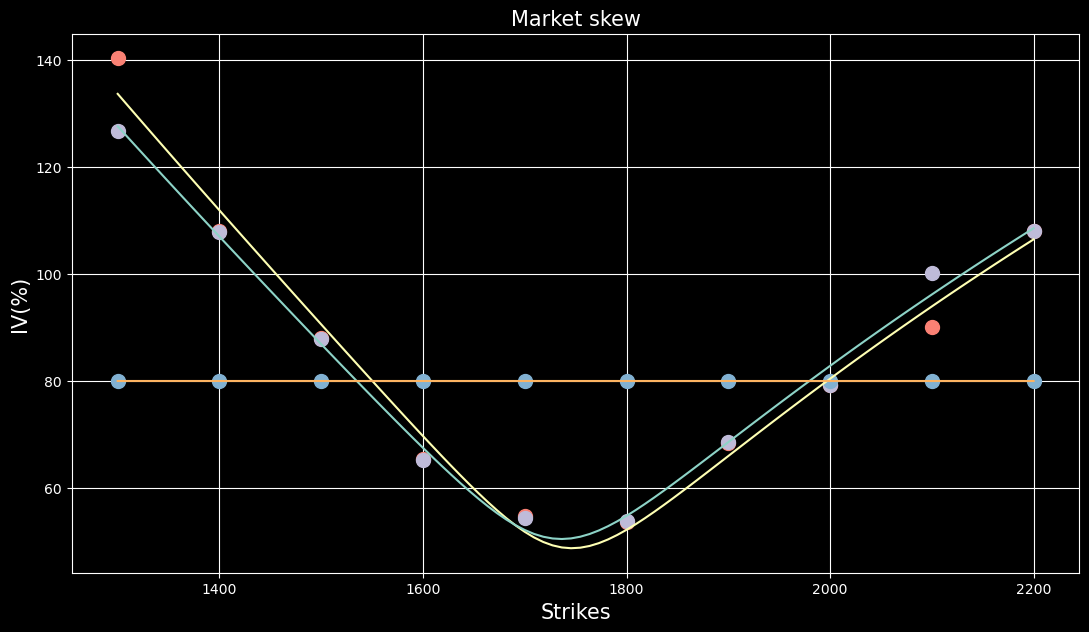

In [62]:
plt.figure(figsize=(13, 7))
plt.plot(strikes, 100*implied_vols, '.C3', markersize=20)
plt.plot(strikes, 100*new_implied_vols, '.C2', markersize=20)
plt.plot(strikes, 100*flat_implied_vols, '.C4', markersize=20)
plt.plot(test_strikes.data, 100*test_iv.data, 'C1')
plt.plot(test_strikes.data, 100*new_test_iv.data, 'C0')
plt.plot(test_strikes.data, 100*flat_test_iv.data, 'C5')
plt.title('Market skew', fontsize=15)
plt.xlabel('Strikes', color='white', fontsize=15)
plt.ylabel('IV(%)', color='white', fontsize=15)
plt.grid()
plt.show()

#### Hagan's original formula

In [63]:
def hagan_implied_volatility(K,T,f,alpha,beta,rho,gamma):
    if type(K) == float:
        K = np.array([K])
    if K is not np.array:
        K = np.array(K).reshape([len(K),1])
    z        = gamma/alpha*np.power(f*K,(1.0-beta)/2.0)*np.log(f/K);
    x_z      = np.log((np.sqrt(1.0-2.0*rho*z+z*z)+z-rho)/(1.0-rho))
    A        = alpha/(np.power(f*K,((1.0-beta)/2.0))*(1.0+np.power(1.0-beta,2.0)/24.0*
                               np.power(np.log(f/K),2.0)+np.power((1.0-beta),4.0)/1920.0*
                               np.power(np.log(f/K),4.0)))
    B1       = 1.0 + (np.power((1.0-beta),2.0)/24.0*alpha*alpha/(np.power((f*K),
                1-beta))+1/4*(rho*beta*gamma*alpha)/(np.power((f*K),
                             ((1.0-beta)/2.0)))+(2.0-3.0*rho*rho)/24.0*gamma*gamma)*T
    impVol   = A*(z/x_z) * B1
    B2 = 1.0 + (np.power(1.0-beta,2.0)/24.0*alpha*alpha/
                (np.power(f,2.0-2.0*beta))+1.0/4.0*(rho*beta*gamma*
                alpha)/np.power(f,(1.0-beta))+(2.0-3.0*rho*rho)/24.0*gamma*gamma)*T;


    impVol[np.where(K==f)] = alpha / np.power(f,(1-beta)) * B2;
    return impVol.flatten()

In [67]:
for new_tenor in [1., .5, .01]:
    print(f'\n////////////// tenor = {new_tenor} ////////////////')
    for beta in [.5, .95,  1.]:
        print(f'============== beta = {beta} =================')
        for scale in [100., 5., 1.]:
            new_strikes = test_strikes.data / scale
            new_calibrated_params.beta = beta
            sabr_calc.implied_vols(
                Forward(Spot(new_forward), ForwardYield(0.), Tenor(new_tenor)),
                Strikes(new_strikes),
                new_calibrated_params
            )
            error = np.abs(
                sabr_calc.implied_vols(
                    Forward(Spot(new_forward), ForwardYield(0.), Tenor(new_tenor)),
                    Strikes(new_strikes),
                    new_calibrated_params).data\
                - hagan_implied_volatility(new_strikes, new_tenor, new_forward, 
                                 new_calibrated_params.alpha, beta, 
                                 new_calibrated_params.rho, new_calibrated_params.v)).max()
            print(f'min strike {new_strikes[0]}, max diff: {error}')


////////////// tenor = 1.0 ////////////////
============== beta = 0.5 =================
min strike 13.0, max diff: 11.217962455403985
min strike 260.0, max diff: 0.7743667846321252
min strike 1300.0, max diff: 0.0031884178861432133
============== beta = 0.95 =================
min strike 13.0, max diff: 0.1771497392197574
min strike 260.0, max diff: 0.011797859287050017
min strike 1300.0, max diff: 5.381313888186412e-05
============== beta = 1.0 =================
min strike 13.0, max diff: 2.842170943040401e-14
min strike 260.0, max diff: 1.4210854715202004e-14
min strike 1300.0, max diff: 2.4868995751603507e-14

////////////// tenor = 0.5 ////////////////
============== beta = 0.5 =================
min strike 13.0, max diff: 6.209556729555352
min strike 260.0, max diff: 0.42862360187198867
min strike 1300.0, max diff: 0.001764816122114432
============== beta = 0.95 =================
min strike 13.0, max diff: 0.09818785963174292
min strike 260.0, max diff: 0.006538474006816841
min str

#### Unexplained PnL 

Given the present values $PV_t$, $S_t$ and calibrated parameters $\alpha_t$, $\rho_t$ and $v_t$, we observe the next update in the market $PV_{t+1}$, $S_{t+1}$, calibrate $\alpha_{t+1}$, $\rho_{t+1}$ and $v_{t+1}$ and measure:

$$
PV_{t+1} - PV_t = \Delta_{PV_t} \cdot (f_{t+1} - f_t) + \frac{1}{2} \Gamma_{PV_t} \cdot(f_{t+1} - f_t)^2
$$
$$
+ \mathcal{V}_{PV_t}\cdot(\alpha_{t+1} - \alpha_t) + \mathcal{R}_{PV_t}\cdot(\rho_{t+1} - \rho_t) + \mathcal{S}_{PV_t}\cdot(v_{t+1} - v_t)
$$
$$
+ \frac{1}{2} \mathcal{Vanna} \cdot (\alpha_{t+1} - \alpha_t) \cdot (f_{t+1} - f_t)   +  \frac{1}{2} \mathcal{Volga} \cdot (\alpha_{t+1} - \alpha_t)^2
$$
$$
+ \text{Unexplained Forward PnL}
$$

Multiply by the numéraire (discount) to get the present value for the unexplained PnL.

#### Delta space
Mapping from delta space:
$$
g(K) = \Delta_{BSM} - \delta \equiv 0 
$$
with implied volatility constrained by SABR is achieved computing the smile sensitivity to the strike:
$$
g'(K) = \frac{N'(d_1)}{\sqrt T} \left( -\frac{1}{K\sigma(K)} - \frac{\sigma'(K) \ln \frac{S}{K}}{\sigma^2(K)} - \frac{rT\sigma'(K)}{\sigma^2(K)} + T\sigma'(K)    \right)
$$

### Managing the vol surface with SABR
For different maturities SABR dynamics take place in different $T$-forward measures. Nevertheless the map to the vol smiles and the associated calibrated parameters: 
$$
T \rightarrow \sigma_i(K_i), \left( \alpha^T, \rho^T, v^T \right)
$$
is continuous in $T$. Therefore, after performing a calibration for each maturity $T_j$ separately, one can perform an interpolation for each of the three parameters $(\alpha^{T_j}, \rho^{T_j}, v^{T_j})$, via a cubic spline for example.
 
#### Calendar Arbitrage
The above approach might lead to **calendar arbitrage**: that is when for each strike $K$ the map 
$$
T \rightarrow \sigma \left(T,K \right)^2T
$$
is not strictly increasing. The quantity on the RHS is called *total implied variance*. 

#### Market data interpolation
A safer approach (but perhaps less efficient) is an interpolation of the market data first. Interpolating the options chain accross tenors is challenging as each tenor typically would contain a different set of strikes. 

A better approach is to map chain space to delta space. This is achieved by calibrating SABR to existing tenors and compute the ATM straddle, risk reversals and butterflies (as we did in the previous section). As those are now free of strikes on can interpolate each of them accross tenors separetely:
$$
T \rightarrow \sigma_{ATM}(T), \sigma_{\delta RR}(T), \sigma_{\delta BB} (T) 
$$
One should get also the forward curve $T \rightarrow f_{t,T}$.

Then, given a new tenor $T_0$ not available in the market data, one maps delta space quotes to the options chain back simply using Black-Scholes (as we did earlier on):
$$
\sigma_{ATM}(T_0), \sigma_{\delta RR}(T_0), \sigma_{\delta BB} (T_0) \rightarrow \sigma(T_0, K_{\delta,p}), \sigma(T_0, f_{t,T}), \sigma(T_0, K_{\delta,c})
$$
and calibrate SABR to it, getting $\alpha^{T_0}, \rho^{T_0}, v^{T_0}$.

#### Greeks on the surface

SABR greeks are computed according to each tenor separetely. For example, the vega of a calendar spread shorting a one-month call $PV_{C,1M}$ and buying a longer dated one, e.g. three-month $PV_{C,3M}$ is:
$$
\mathcal{V}_{PV_{C,3M}-PV_{C,1M}} = \frac{\partial PV_{C,3M}}{\partial \alpha_{3M}} - \frac{\partial PV_{C,1M}}{\partial \alpha_{1M}}
$$

Similarly for volga, rega and sega. 

For delta (and gamma for that matter), this calculation is easier as we just differentiate w.r.t. spot:
$$
\Delta_{PV_{C,3M}-PV_{C,1M}} = \frac{\partial PV_{C,3M}}{\partial S_t} - \frac{\partial PV_{C,1M}}{\partial S_t}
$$

Finally, vanna risk is defined as sensitivity of vega to spot, so it will read:
$$
\text{Vanna}_{PV_{C,3M}-PV_{C,1M}} = \frac{\partial}{\partial S_t}\mathcal{V}_{PV_{C,3M}-PV_{C,1M}} =  \frac{\partial^2 PV_{C,3M}}{\partial S_t \partial \alpha_{3M}} - \frac{\partial^2 PV_{C,1M}}{\partial S_t \partial \alpha_{1M}}
$$

## 4. Heston calibration
This is a stochastic volatility model for the forward dynamics in the risk neutral measure, and CIR dynamics for the variance:
$$
\left\{
\begin{array}{l}
    \text{d}X_t =  \sqrt{V_t} X_t \text{d}W_t^X,  \\
    \text{d}V_t =  \kappa (\theta - V_t)\text{d}t + \varepsilon \sqrt{V_t} \text{d} W_t^V,
\end{array}\right.
$$

where underlying Brownian motions are correlated:
$$ \text{d} W_t^V = \rho\text{d}W_t^X + \sqrt{1-\rho^2} \text{d}W_t,$$
$$ -1 < \rho < 1 $$

The forward price of a call option is given by:
$$
\text{FV}_C(t_0, T, K) = X_{t_0} H(\sqrt{-1}) - K \cdot H(0)
$$
where
$$
H(z) = \frac{1}{2} + \frac{1}{\pi} \int^{\infty}_0 \mathbf{Re} \left[ \frac{e^{u\sqrt{-1} \log \frac{X_{t_0}}{K}}}{u\sqrt{-1}} \phi(u-z,T) \right]\text{d}u
$$
with 
$$
\phi(u,T) = \exp \left( - \frac{\kappa\theta\rho T u\sqrt{-1} }{\varepsilon} - A + \frac{2 \kappa \theta }{\varepsilon^2}D\right).
$$
Here $A = A_1 / A_2$:
$$
A_1 = (u^2 + u\sqrt{-1}) \sinh \frac{q T}{2}, \quad q = \sqrt{ \xi^2 + \varepsilon^2 (u^2 + u\sqrt{-1})}, \quad \xi = \kappa - \varepsilon\rho u\sqrt{-1}
$$
$$
\log A_2 = \frac{q T}{2} + \log \left( \frac{q +\xi}{2 V_{t_0}} + \frac{q  - \xi}{2V_{t_0}}e^{-q T}\right),
$$

and
$$
D = \log \frac{q}{V_{t_0}} + \frac{\kappa T}{2} - \log A_2.
$$

The integral above can be truncated to $(0,200)$ and evaluated via Gaussian quadrature at 64 nodes for $10^{-10}$ accuracy.

#### 4.1 Delta computation
See that:

$$\text{FV}_C(\lambda X_{t_0}, T, \lambda K) = \lambda \text{FV}_C(X_{t_0}, T, K).$$

So, formula is homogeneous of order one. Differentiating both sides with respect to $\lambda$:

$$X_{t_0} \frac{\partial \text{FV}_C}{\partial X_{t_0}} + K \frac{\partial \text{FV}_C}{\partial K} = \text{FV}_C.$$

Comparing with equation for call-option:

$$\Delta = \frac{\partial \text{FV}_C}{\partial X_{t_0}} = H(i).$$

### References
* Hagan, P. S. et al. *Implied volatility formulas for Heston models.* Wilmott 2018.98 (2018)
* Hagan, P.S., Lesniewski, A.S. and Woodward, D.E., *Managing vol surfaces*. Wilmott (93), pp.24-43, (2018)
* Bartlett, B. *Hedging Under SABR Model.* Wilmott Magazine, (2006)
* Oblój, J. *Fine-Tune Your Smile: Correction to Hagan et al*. preprint arXiv:0708.0998 (2007)
* Paulot, L. *Asymptotic implied volatility at the second order with application to the SABR model.* In Large Deviations and Asymptotic Methods in Finance (pp. 37-69). Springer, Cham. (2015)
* Henry-Labordere, P. *A general asymptotic implied volatility for stochastic volatility models.* http://arxiv.org/abs/cond-mat/0504317 (2005)